### Tutorial: how to use `pangeo-fish`


**Overview.**

This Jupyter notebook demonstrates how to use `pangeo-fish`.

Specifically, we will fit the geolocation on the data from the study conducted by M. Gonze et al. titled "Combining acoustic telemetry with archival tagging to investigate the spatial dynamics of the understudied pollack *Pollachius pollachius*", accepted for publication in the Journal of Fish Biology.

We will use the biologging tag "A19124", which was attached to pollack fish.

As for the reference Earth Observation (EO) data, we consider the European Union Copernicus Marine Service Information (CMEMS) product "NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013".

_NB: In addition to the Data Storage Tag (DST), the biologging data includes **teledetection by acoustic signals**, as well as the release and recapture/death information of the fish._

Both the reference EO and the biologging data are publicly available, and the computations should be tractable for most standard laptops.

**Workflow.**

Let's first summarize the key steps for running the geolocation:

1. **Define the configuration:** define the required parameters for the analysis.
2. **Compare the reference data with the DST information:** compare the data from the reference model with the biologging data. 
3. **Regrid the comparison to HEALPix:** translate the comparison into a HEALPix grid to avoid spatial distortion.
4. **Construct the temporal emission matrix:** create a temporal emission probability distribution (_pdf_) from the transformed grid.
5. **Construct another emission matrix with the acoustic detections:** calculate a similar model to the previous one, using this time the acoustic teledetections.
6. **Combine and normalize the matrices:** merge and normalize the two _pdfs_.
7. **Estimate (or _fit_) the geolocation model:** determine the parameters of the model based on the normalized emission matrix.
8. **Compute the state probabilities and generate trajectories:** compute the fish's location probability distribution and generate subsequent trajectories.
9. **Visualization:** visualize the evolution of the spatial probabilities over time and export the video.

Throughout this tutorial, you will gain practical experience in setting up and executing a typical workflow using `pangeo-fish` such that you can then apply the tool with your use-case study.

## 1. Initialization and configuration definition

In this step, we prepare the execution of the analysis.
It includes:
- Installing the necessary packages.
- Importing the required libraries.
- Defining the parameters for the next stages of the workflow.
- Configuring the cluster for distributed computing.
    

In [1]:
tag_name = "208992_argos"

In [2]:
import sys

import hvplot.xarray
import xarray as xr
from pint_xarray import unit_registry as ureg

sys.path.append("../")
import pangeo_fish

In [3]:
# tag_name corresponds to the name of the biologging tag name (DST identification number),
# which is also a path for storing all the information for the specific fish tagged with tag_name.

#tag_save = "228035"
# tag_root specifies228036 the root URL for tag data used for this computation.
tag_root = "s3://gfts-ifremer/fra_sodeika/tags/formatted"

# ref_url is the path to the reference model

# Liste des tags de 2021
tags_2021 = ["203226_argos", "208991_argos", "208992_argos", "208992_archival", "208993_argos"]

if tag_name in tags_2021:
    ref_model_file = "~/ECAP_FORK/light_pdf/ecap_jmarc_try/okuyama/tags/copernicus_ref_model/copernicus_jpn_daily_feb_mar_2021.zarr/"
else:
    ref_model_file = "~/ECAP_FORK/light_pdf/ecap_jmarc_try/okuyama/tags/copernicus_ref_model/copernicus_jpn_daily_20220105.zarr/"
# scratch_root specifies the root directory for storing output files.
# storage_options specifies options for the filesystem storing output files.

## example for remote storage
#scratch_root = "s3://gfts-ifremer/fra_sodeika/run/capetienne/papermill_copernicus/same_bbox"
scratch_root = "s3://gfts-ifremer/fra_sodeika/run/capetienne/papermill_copernicus/same_bbox/foscat_daily/variable_std"
storage_options = {
    "anon": False,
    "profile": "gfts",
    "client_kwargs": {
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
        "region_name": "gra",
    },
}
## example for using your local file system instead
# scratch_root = "."
# storage_options = None

# Default chunk value for time dimension.  This values depends on the configuration of your dask cluster.
chunk_time = 1

# Either to use a HEALPix grid (["cells"]) or a 2D grid (["x", "y"])
dims = ["cells"]

# bbox, bounding box, defines the latitude and longitude range for the analysis area.
bbox = {"latitude": [16, 25], "longitude": [117, 130]}
bbox = {"latitude": [20, 30], "longitude": [117, 135]}
bbox = {"latitude": [16, 35], "longitude": [120, 145]}

# bbox = {"latitude": [20, 35], "longitude": [125, 140]}

# relative_depth_threshold defines the acceptable fish depth relative to the maximum tag depth.
# It determines whether the fish can be considered to be in a certain location based on depth.
relative_depth_threshold = 0

# optional rotation for the HEALPix grid
rot = {"lat": 0, "lon": 0}
# nside defines the resolution of the healpix grid used for regridding.
nside = 1024
refinement_level = 10 
# min_vertices sets the minimum number of vertices for a valid transcription for regridding.
min_vertices = 1

# differences_std sets the standard deviation for scipy.stats.norm.pdf.
# It expresses the estimated certainty of the field of difference.
differences_std = 1.0
# initial_std sets the covariance for initial event.
# It shows the certainty of the initial area.
initial_std = 1e-4
# recapture_std sets the covariance for recapture event.
# It shows the certainty of the final recapture area if it is known.
recapture_std = 1e-4
# earth_radius defines the radius of the Earth used for distance calculations.
earth_radius = ureg.Quantity(6371, "km")
# maximum_speed sets the maximum allowable speed for the tagged fish.
maximum_speed = ureg.Quantity(120, "km / day")
# adjustment_factor adjusts parameters for a more fuzzy search.
# It will factor the allowed maximum displacement of the fish.
adjustment_factor = 5
# truncate sets the truncating factor for computed maximum allowed sigma for convolution process.
truncate = 4

# tolerance describes the tolerance level of the search during the fitting/optimization of the geolocation.
# Smaller values will make the optimization iterate more
tolerance = 1e-3 if dims == ["x", "y"] else 1e-4

# track_modes defines the modes for generating fish's trajectories.
track_modes = ["mean", "mode"]

# additional_track_quantities sets quantities to compute for tracks using moving pandas.
additional_track_quantities = ["speed", "distance"]


# time_step defines the time interval between each frame of the visualization
time_step = 3

In [4]:
# Define target root directories for storing analysis results.
target_root = f"{scratch_root}/{tag_name}"

# Defines default chunk size for optimization.
default_chunk = {"time": chunk_time, "lat": -1, "lon": -1}
default_chunk_dims = {"time": chunk_time}
default_chunk_dims.update({d: -1 for d in dims})

In [5]:
# Set up a local cluster for distributed computing.
from distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 149.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36467,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 149.01 GiB
Comm: tcp://127.0.0.1:39723,Total threads: 4
Dashboard: http://127.0.0.1:45133/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:43947,


Now that everything is set up, we can start by loading the biologging data (or _tag_)

In [6]:
from pangeo_fish.helpers import load_tag

tag, tag_log, time_slice = load_tag(
    tag_root=tag_root, tag_name=tag_name, storage_options=storage_options
)
tag

/srv/conda/envs/notebook/lib/python3.12/site-packages/movingpandas/__init__.py:41: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


<xarray.DataTree>
Group: /
│   Attributes:
│       pit_tag_id:        208992
│       acoustic_tag_id:   NA
│       scientific_name:   Unknow
│       common_name:       okuyama
│       tagging_campaign:  JP
│       tag_name:          208992_argos
├── Group: /dst
│       Dimensions:      (time: 789)
│       Coordinates:
│         * time         (time) datetime64[ns] 6kB 2021-02-22T05:15:00 ... 2021-02-24...
│       Data variables:
│           temperature  (time) float64 6kB 18.8 17.55 16.9 16.9 ... 11.6 11.6 11.6 12.6
│           pressure     (time) float64 6kB 236.5 265.8 289.2 ... 518.8 518.8 432.2
└── Group: /tagging_events
        Dimensions:     (event_name: 2)
        Coordinates:
          * event_name  (event_name) object 16B 'release' 'fish_death'
        Data variables:
            time        (event_name) datetime64[ns] 16B 2021-02-22T05:15:00 2021-02-2...
            longitude   (event_name) float64 16B 122.6 122.9
            latitude    (event_name) float64 16B 23.59 23.84

You can plot the time series of the DST with the function `plot_tag()`:

In [7]:
from pangeo_fish.helpers import plot_tag

plot = plot_tag(
    tag=tag,
    tag_log=tag_log,
    # you can directly save the plot if you want
    save_html=True,
    storage_options=storage_options,
    target_root=target_root,
)
plot

:Overlay
   .Curve.I    :Curve   [time]   (pressure)
   .Scatter.I  :Scatter   [time]   (pressure)
   .Curve.II   :Curve   [time]   (temperature)
   .Scatter.II :Scatter   [time]   (temperature)

## 2. Compare the reference data with the DST logs

In this step, we compare the reference model data with Data Storage Tag information.
The process involves reading and cleaning the reference model, aligning time, converting depth units and subtracting the tag data from the model.
We also illustrate how to plot and saving the result.

In [8]:
import xarray as xr
from pangeo_fish.helpers import _open_parquet_model, load_model, prepare_dataset

ref_ds = xr.open_dataset(
    ref_model_file,
    engine="zarr",
    chunks={},
    storage_options=None,
)


model = prepare_dataset(ref_ds)
model

<xarray.Dataset> Size: 4GB
Dimensions:             (depth: 50, lat: 361, lon: 301, time: 40)
Coordinates:
  * depth               (depth) float32 200B 0.494 1.541 ... 5.275e+03 5.728e+03
  * lat                 (lat) float32 1kB 15.0 15.08 15.17 ... 44.83 44.92 45.0
  * lon                 (lon) float32 1kB 115.0 115.1 115.2 ... 139.9 140.0
  * time                (time) datetime64[ns] 320B 2021-02-20 ... 2021-03-31
    latitude            (lat, lon) float32 435kB 15.0 15.0 15.0 ... 45.0 45.0
    longitude           (lat, lon) float32 435kB 115.0 115.1 ... 139.9 140.0
Data variables:
    H0                  (lat, lon) float32 435kB dask.array<chunksize=(361, 301), meta=np.ndarray>
    TEMP                (time, depth, lat, lon) float64 2GB dask.array<chunksize=(8, 11, 361, 301), meta=np.ndarray>
    XE                  (time, lat, lon) float64 35MB dask.array<chunksize=(8, 361, 301), meta=np.ndarray>
    dynamic_depth       (depth, time, lat, lon) float64 2GB dask.array<chunksize=(50, 8, 361, 301), meta=np.ndarray>
    dynamic_bathymetry  (lat, lon, time) float64 35MB dask.array<chunksize=(361, 301, 8), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.4
    comment:                   CMEMS product
    copernicusmarine_version:  2.1.0
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...

In [9]:
from pangeo_fish.cf import bounds_to_bins
from pangeo_fish.tags import adapt_model_time, reshape_by_bins, to_time_slice

reference_model = (
    model.sel(time=adapt_model_time(time_slice))
    .sel(lat=slice(*bbox["latitude"]), lon=slice(*bbox["longitude"]))
    .pipe(
        lambda ds: ds.sel(
            depth=slice(None, (tag_log["pressure"].max() - ds["XE"].min()).compute())
        )
    )
).chunk({"time": chunk_time, "lat": -1, "lon": -1, "depth": -1})
reference_model

<xarray.Dataset> Size: 61MB
Dimensions:             (depth: 33, lat: 229, lon: 241, time: 2)
Coordinates:
  * depth               (depth) float32 132B 0.494 1.541 2.646 ... 541.1 643.6
  * lat                 (lat) float32 916B 16.0 16.08 16.17 ... 34.83 34.92 35.0
  * lon                 (lon) float32 964B 120.0 120.1 120.2 ... 139.9 140.0
  * time                (time) datetime64[ns] 16B 2021-02-23 2021-02-24
    latitude            (lat, lon) float32 221kB dask.array<chunksize=(229, 241), meta=np.ndarray>
    longitude           (lat, lon) float32 221kB dask.array<chunksize=(229, 241), meta=np.ndarray>
Data variables:
    H0                  (lat, lon) float32 221kB dask.array<chunksize=(229, 241), meta=np.ndarray>
    TEMP                (time, depth, lat, lon) float64 29MB dask.array<chunksize=(1, 33, 229, 241), meta=np.ndarray>
    XE                  (time, lat, lon) float64 883kB dask.array<chunksize=(1, 229, 241), meta=np.ndarray>
    dynamic_depth       (depth, time, lat, lon) float64 29MB dask.array<chunksize=(33, 1, 229, 241), meta=np.ndarray>
    dynamic_bathymetry  (lat, lon, time) float64 883kB dask.array<chunksize=(229, 241, 1), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.4
    comment:                   CMEMS product
    copernicusmarine_version:  2.1.0
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...

In [10]:
import pandas as pd
from pangeo_fish.cf import bounds_to_bins
from pangeo_fish.tags import adapt_model_time, reshape_by_bins, to_time_slice

start = pd.Timestamp(tag_log["time"].min().item())
end = pd.Timestamp(tag_log["time"].max().item())

extended_time_slice = slice(start - pd.Timedelta("1D"), end )

reference_model = (
    model.sel(time=adapt_model_time(extended_time_slice))
    .sel(lat=slice(*bbox["latitude"]), lon=slice(*bbox["longitude"]))
    .pipe(
        lambda ds: ds.sel(
            depth=slice(None, (tag_log["pressure"].max() - ds["XE"].min()).compute())
        )
    )
).chunk({"time": chunk_time, "lat": -1, "lon": -1, "depth": -1})

reference_model

<xarray.Dataset> Size: 91MB
Dimensions:             (depth: 33, lat: 229, lon: 241, time: 3)
Coordinates:
  * depth               (depth) float32 132B 0.494 1.541 2.646 ... 541.1 643.6
  * lat                 (lat) float32 916B 16.0 16.08 16.17 ... 34.83 34.92 35.0
  * lon                 (lon) float32 964B 120.0 120.1 120.2 ... 139.9 140.0
  * time                (time) datetime64[ns] 24B 2021-02-22 ... 2021-02-24
    latitude            (lat, lon) float32 221kB dask.array<chunksize=(229, 241), meta=np.ndarray>
    longitude           (lat, lon) float32 221kB dask.array<chunksize=(229, 241), meta=np.ndarray>
Data variables:
    H0                  (lat, lon) float32 221kB dask.array<chunksize=(229, 241), meta=np.ndarray>
    TEMP                (time, depth, lat, lon) float64 44MB dask.array<chunksize=(1, 33, 229, 241), meta=np.ndarray>
    XE                  (time, lat, lon) float64 1MB dask.array<chunksize=(1, 229, 241), meta=np.ndarray>
    dynamic_depth       (depth, time, lat, lon) float64 44MB dask.array<chunksize=(33, 1, 229, 241), meta=np.ndarray>
    dynamic_bathymetry  (lat, lon, time) float64 1MB dask.array<chunksize=(229, 241, 1), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.4
    comment:                   CMEMS product
    copernicusmarine_version:  2.1.0
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...

In [11]:
%%time
# Reshape the tag log, so that it bins to the time step of reference_model
reshaped_tag = reshape_by_bins(
    tag_log,
    dim="time",
    bins=(
        reference_model.cf.add_bounds(["time"], output_dim="bounds")
        .pipe(bounds_to_bins, bounds_dim="bounds")
        .get("time_bins")
    ),
    other_dim="obs",
).chunk({"time": chunk_time})

reshaped_tag

CPU times: user 24.8 ms, sys: 92 µs, total: 24.8 ms
Wall time: 23.7 ms


<xarray.Dataset> Size: 16kB
Dimensions:      (time: 3, obs: 288)
Coordinates:
  * obs          (obs) int64 2kB 0 1 2 3 4 5 6 7 ... 281 282 283 284 285 286 287
  * time         (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
Data variables:
    temperature  (time, obs) float64 7kB dask.array<chunksize=(1, 288), meta=np.ndarray>
    pressure     (time, obs) float64 7kB dask.array<chunksize=(1, 288), meta=np.ndarray>
Attributes:
    pit_tag_id:        208992
    acoustic_tag_id:   NA
    scientific_name:   Unknow
    common_name:       okuyama
    tagging_campaign:  JP
    tag_name:          208992_argos

#### VARIANCE

In [12]:
import numpy as np
import xarray as xr


def compute_hist2d(results, nbins_diff=50, nbins_depth=1000, max_depth=None):
    all_diff = np.concatenate([r['diff'] for r in results]) if results else np.array([])
    all_pres = np.concatenate([r['pres'] for r in results]) if results else np.array([])

    mask = np.isfinite(all_diff) & np.isfinite(all_pres)
    all_diff, all_pres = all_diff[mask], all_pres[mask]

    if all_diff.size == 0:
        return None, None, None

    # Depth limit
    if max_depth is not None:
        depth_mask = all_pres <= max_depth
        all_diff, all_pres = all_diff[depth_mask], all_pres[depth_mask]

    dmin, dmax = np.nanpercentile(all_diff, [1, 99])
    dmax_abs = max(abs(dmin), abs(dmax))
    diff_bins = np.linspace(-dmax_abs, dmax_abs, nbins_diff+1)
    depth_bins = np.linspace(0, max_depth if max_depth is not None else np.nanpercentile(all_pres, 98), nbins_depth+1)

    counts, xedges, yedges = np.histogram2d(all_diff, all_pres, bins=[diff_bins, depth_bins])
    return counts, xedges, yedges


def variance_by_depth(counts, xedges):
    """
    Computes the weighted variance of ΔT for each row (depth)
    from the 2D histogram.
    """
    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    
    weights_sum = counts.sum(axis=0)
    
    weights_sum[weights_sum == 0] = np.nan

    mean = np.nansum(counts * xcenters[:, None], axis=0) / weights_sum

    var = np.nansum(counts * (xcenters[:, None] - mean)**2, axis=0) / weights_sum

    var_norm = var / np.nanmax(var)

    return var, var_norm


In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


with open("../comp_argos_model_files/results_copernicus.pkl", "rb") as f:
    results_jamstec = pickle.load(f)


counts_j, xedges, yedges = compute_hist2d(results_copernicus , max_depth=2000)

var_j, var_j_norm = variance_by_depth(counts_j, xedges)

In [14]:
from scipy.interpolate import interp1d
import numpy as np

def variance_interp_function(yedges, var):
    depth_centers = 0.5 * (yedges[:-1] + yedges[1:])
    f_var = interp1d(depth_centers, var, bounds_error=False,
                     fill_value=(var[0], var[-1]))
    return f_var


def std_interp_function(yedges, var):
    depth_centers = 0.5 * (yedges[:-1] + yedges[1:])
    
    std = np.sqrt(var)
    
    f_std = interp1d(
        depth_centers,
        std,
        bounds_error=False,
        fill_value=(std[0], std[-1])
    )
    
    return f_std

    
def temperature_interp_function(model_depth, model_temp):

    f_temp = interp1d(
        model_depth,
        model_temp,
        bounds_error=False,
        fill_value=(model_temp[0], model_temp[-1])
    )
    return f_temp



In [15]:
yedges

array([   0.,    2.,    4., ..., 1996., 1998., 2000.])

In [16]:
f_var = variance_interp_function(yedges, var_j)
f_std = std_interp_function(yedges,var_j)

In [17]:
len(var_j)

1000

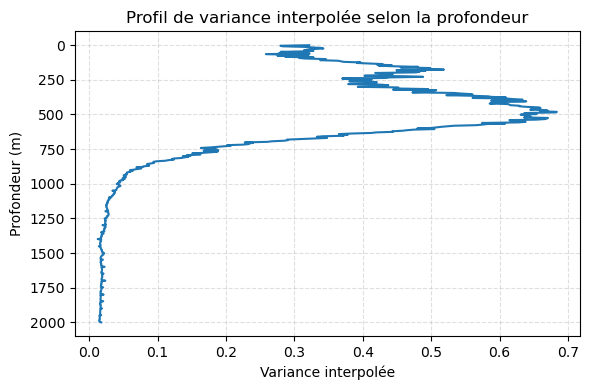

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# f_var déjà défini via variance_interp_function(yedges, var_j)
depths = np.linspace(0, 2000, 500)
var_profile = f_var(depths)

plt.figure(figsize=(6, 4))
plt.plot(var_profile, depths, color='tab:blue')
plt.gca().invert_yaxis()
plt.xlabel("Variance interpolée")
plt.ylabel("Profondeur (m)")
plt.title("Profil de variance interpolée selon la profondeur")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [19]:
from pangeo_fish.diff import diff_z_var
diff = (
    diff_z_var(
        reference_model,
        reshaped_tag,
        var_depth=(0.5 * (yedges[:-1] + yedges[1:])),
        var_values=var_j,
        
    )
    .assign(
        {
            "H0": reference_model["H0"],
            "XE": reference_model["XE"],
            "ocean_mask": reference_model["H0"].notnull(),
        }
    )
)


In [20]:
%%time
diff = diff.compute()

/srv/conda/envs/notebook/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: invalid value encountered in _diff_z_var
  return self.ufunc(*args, **kwargs)


CPU times: user 1.04 s, sys: 179 ms, total: 1.22 s
Wall time: 7.88 s


/srv/conda/envs/notebook/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: invalid value encountered in _diff_z_var
  return self.ufunc(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:261: RuntimeWarning: invalid value encountered in _diff_z_var
  return self.ufunc(*args, **kwargs)


In [22]:
diff

<xarray.Dataset> Size: 3MB
Dimensions:     (lat: 229, lon: 241, time: 3)
Coordinates:
  * lat         (lat) float32 916B 16.0 16.08 16.17 16.25 ... 34.83 34.92 35.0
  * lon         (lon) float32 964B 120.0 120.1 120.2 120.2 ... 139.8 139.9 140.0
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
    latitude    (lat, lon) float32 221kB 16.0 16.0 16.0 16.0 ... 35.0 35.0 35.0
    longitude   (lat, lon) float32 221kB 120.0 120.1 120.2 ... 139.8 139.9 140.0
Data variables:
    diff        (time, lat, lon) float64 1MB nan nan 252.7 ... 172.7 nan 169.1
    H0          (lat, lon) float32 221kB nan nan 12.0 10.0 ... 29.69 nan 25.5
    XE          (time, lat, lon) float64 1MB nan nan 0.6888 ... nan 0.1852
    ocean_mask  (lat, lon) bool 55kB False False True True ... True False True

### end test 

<xarray.Dataset> Size: 3MB
Dimensions:     (lat: 229, lon: 241, time: 3)
Coordinates:
  * lat         (lat) float32 916B 16.0 16.08 16.17 16.25 ... 34.83 34.92 35.0
  * lon         (lon) float32 964B 120.0 120.1 120.2 120.2 ... 139.8 139.9 140.0
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
    latitude    (lat, lon) float32 221kB 16.0 16.0 16.0 16.0 ... 35.0 35.0 35.0
    longitude   (lat, lon) float32 221kB 120.0 120.1 120.2 ... 139.8 139.9 140.0
Data variables:
    diff        (time, lat, lon) float64 1MB nan nan 25.28 ... 160.4 nan 161.6
    H0          (lat, lon) float32 221kB nan nan 12.0 10.0 ... 29.69 nan 25.5
    XE          (time, lat, lon) float64 1MB nan nan 0.6888 ... nan 0.1852
    ocean_mask  (lat, lon) bool 55kB False False True True ... True False True

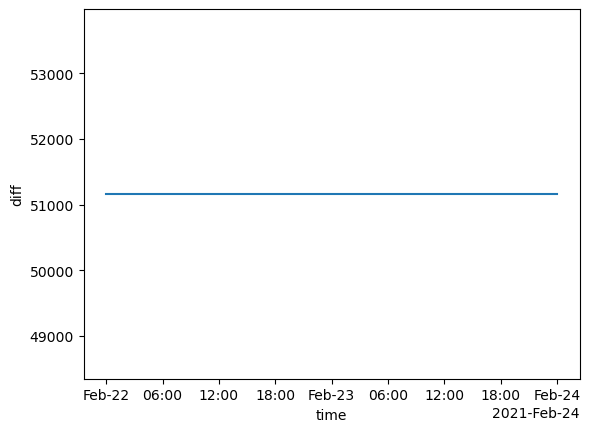

In [21]:
diff["diff"].count(["lat", "lon"]).plot()
diff

In [21]:
diff.compute().to_zarr(
    f"{target_root}/diff.zarr",
    mode="w",
    storage_options=storage_options,
    zarr_version=2,
)

del diff

/tmp/ipykernel_26258/1454463285.py:1: FutureWarning: zarr_version is deprecated, use zarr_format
  diff.compute().to_zarr(


## 3. HEALPix regridding

In this step, we regrid the data from above to HEALPix coordinates. 

This is a complex process, composed of several steps such as defining the HEALPix grid, creating the target grid and computing interpolation weights

Fortunately though, `pangeo-fish` embarks high-level functions to do the work for us!

In [22]:
from pangeo_fish.helpers import open_diff_dataset, regrid_dataset

# Open the previous dataset (only necessary if you resume the notebook from here)
diff = open_diff_dataset(target_root=target_root, storage_options=storage_options)
diff

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 3, yi: 229, xi: 241)
Coordinates:
    latitude    (yi, xi) float32 221kB 16.0 16.0 16.0 16.0 ... 35.0 35.0 35.0
    longitude   (yi, xi) float32 221kB 120.0 120.1 120.2 ... 139.8 139.9 140.0
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
Dimensions without coordinates: yi, xi
Data variables:
    diff        (time, yi, xi) float64 1MB dask.array<chunksize=(2, 115, 121), meta=np.ndarray>
    H0          (yi, xi) float32 221kB dask.array<chunksize=(229, 241), meta=np.ndarray>
    ocean_mask  (yi, xi) bool 55kB dask.array<chunksize=(229, 241), meta=np.ndarray>
    XE          (time, yi, xi) float64 1MB dask.array<chunksize=(1, 229, 241), meta=np.ndarray>

In [23]:
reshaped = regrid_dataset(
    ds=diff, refinement_level=10, min_vertices=min_vertices, rot=rot, dims=dims
)[0]
reshaped

/srv/conda/envs/notebook/lib/python3.12/site-packages/xhealpixify/interpolation/mask.py:22: RuntimeWarning: invalid value encountered in divide
  return masked_weights / np.sum(masked_weights, axis=-1)[:, None]


<xarray.Dataset> Size: 9MB
Dimensions:     (cells: 103284, time: 3)
Coordinates:
    cell_ids    (cells) int64 826kB 1105367 1105371 1105372 ... 1648725 1648726
    latitude    (cells) float64 826kB 16.06 16.06 16.06 ... 34.91 34.95 34.95
    longitude   (cells) float64 826kB 138.8 138.6 138.7 ... 120.1 120.2 120.1
    resolution  float64 8B 0.0009993
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
Dimensions without coordinates: cells
Data variables:
    diff        (time, cells) float64 2MB dask.array<chunksize=(2, 103284), meta=np.ndarray>
    H0          (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    ocean_mask  (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    XE          (time, cells) float64 2MB dask.array<chunksize=(1, 103284), meta=np.ndarray>
Attributes:
    grid_type:     healpix
    level:         10
    nside:         1024
    lat:           0
    lon:           0
    rot_lat:       0
    rot_lon:       0
    comment:       pangeo-fish == 2025.3.4.dev15+ge4fe03374.d20251103, healpi...
    min_vertices:  1

Let's plot the same chart as before to check that the HEALPix regridding hasn't changed the data

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 12.44 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


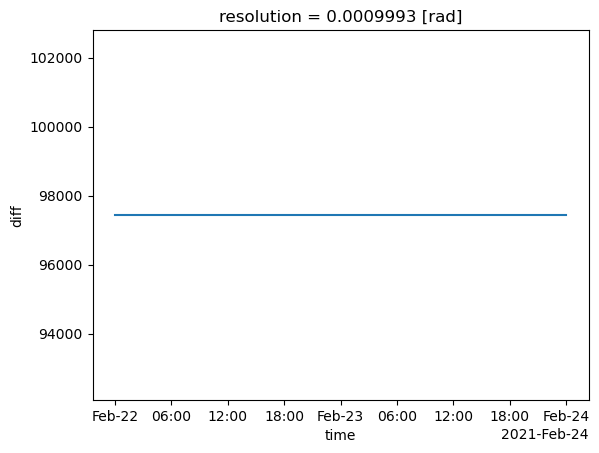

In [24]:
reshaped["diff"].count(dims).plot()

In [25]:
reshaped["diff"].compute().dggs.decode(
    {"grid_name": "healpix", "level": 10, "indexing_scheme": "nested"}
).dggs.explore(alpha=0.8)

MapWithSliders(children=(Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro…

In [26]:
# Saves the result
reshaped.chunk(default_chunk_dims).to_zarr(
    f"{target_root}/diff-regridded.zarr",
    mode="w",
    consolidated=True,
    compute=True,
    storage_options=storage_options,
    zarr_version=2,
)
del reshaped

/tmp/ipykernel_26258/1492199169.py:2: FutureWarning: zarr_version is deprecated, use zarr_format
  reshaped.chunk(default_chunk_dims).to_zarr(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## 4. Compute the emission probability distribution

In this step, we use the comparison result from the step above to construct the emission probability matrix.

This comparison is essentially he differences between the temperature measured by the tag and the reference sea temperature. 

The emission probability matrix represents the likelihood of observing a specific temperature difference given the model parameters and configurations.

In [27]:
from pangeo_fish.helpers import compute_emission_pdf

In [28]:
# Open the previous dataset (only necessary if you resume the notebook from here)
differences = xr.open_dataset(
    f"{target_root}/diff-regridded.zarr",
    engine="zarr",
    chunks={},
    storage_options=storage_options,
).pipe(lambda ds: ds.merge(ds[["latitude", "longitude"]].compute()))
# ... and compute the emission matrices
emission_pdf = compute_emission_pdf(
    diff_ds=differences,
    events_ds=tag["tagging_events"].ds,
    differences_std=differences_std,
    initial_std=initial_std,
    recapture_std=recapture_std,
    dims=dims,
    chunk_time=chunk_time,
)[0]
emission_pdf

<xarray.Dataset> Size: 7MB
Dimensions:     (cells: 103284, time: 3)
Coordinates:
  * cell_ids    (cells) int64 826kB 1105367 1105371 1105372 ... 1648725 1648726
    latitude    (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    longitude   (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    resolution  float64 8B 0.0009993
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
Dimensions without coordinates: cells
Data variables:
    pdf         (time, cells) float64 2MB dask.array<chunksize=(1, 103284), meta=np.ndarray>
    initial     (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    final       (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    mask        (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=10, indexing_scheme=nested, kind=pandas)
Attributes:
    grid_type:        healpix
    level:            10
    nside:            1024
    lat:              0
    lon:              0
    rot_lat:          0
    rot_lon:          0
    comment:          pangeo-fish == 2025.3.4.dev15+ge4fe03374.d20251103, hea...
    min_vertices:     1
    differences_std:  1.0
    recapture_std:    0.0001
    initial_std:      0.0001

In [29]:
emission_pdf.pdf.compute().dggs.decode(
    {"grid_name": "healpix", "level": 10, "indexing_scheme": "nested"}
).dggs.explore(alpha=0.8)

MapWithSliders(children=(Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro…

Whatever the temporal distribution looks like, they must **never** (i.e, at _any time step_) sum to 0.

How could we check that visually? You'd have guessed it by now: similarly as before!

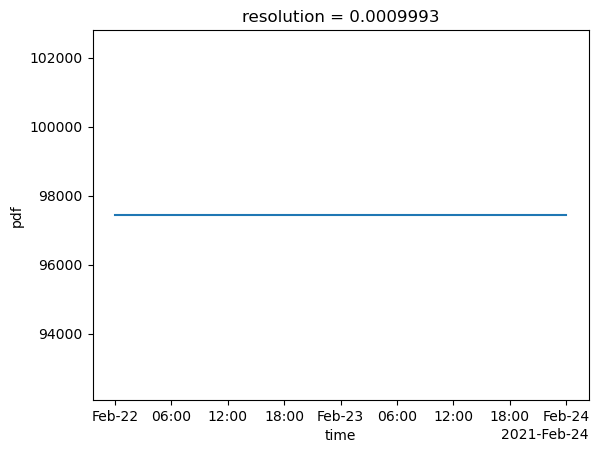

In [30]:
emission_pdf = emission_pdf.chunk(default_chunk_dims).persist()
emission_pdf["pdf"].count(dims).plot()

In [31]:
# Save the dataset
emission_pdf.compute().to_zarr(
    f"{target_root}/emission.zarr",
    mode="w",
    consolidated=True,
    storage_options=storage_options,
    zarr_version=2,
)

/tmp/ipykernel_26258/3772922378.py:2: FutureWarning: zarr_version is deprecated, use zarr_format
  emission_pdf.compute().to_zarr(


## 5. Compute and add bathy pdf

In [32]:
import fsspec
from pangeo_fish.bathy import batch_compute_pdf_bathy
from pangeo_fish.cf import bounds_to_bins
from pangeo_fish.tags import adapt_model_time, reshape_by_bins, to_time_slice

# Ton chemin cible
zarr_path = f"s3://gfts-ifremer/fra_sodeika/run/capetienne/papermill_copernicus/same_bbox/foscat_daily/bathy_pdf_{tag_name}.zarr"

# Ouvre un filesystem compatible avec tes storage_options (ex: S3)
fs = fsspec.filesystem('s3', **storage_options)
bool_bathy=fs.exists(zarr_path)
# Vérifie si le dossier/fichier Zarr existe déjà
if bool_bathy:
    print(f"⚠️ Le fichier {zarr_path} existe déjà — calcul sauté.")
else:
    print(f"✅ Aucun fichier trouvé, lancement du calcul...")


if bool_bathy: 
    bathy_pdf = xr.open_dataset(
        f"s3://gfts-ifremer/fra_sodeika/run/capetienne/papermill_copernicus/same_bbox/foscat_daily/bathy_pdf_{tag_name}.zarr",
        engine="zarr",
        chunks={},
        storage_options=storage_options,
    )
else:
    import healpy as hp
    from pangeo_fish.bathy import (
        compute_fish_histogram_bin_size,
        compute_healpix_histogram_region_bin_size,
    )
    
    # Open the previous dataset (only necessary if you resume the notebook from here)
    full_bathy = xr.open_dataset(
        "s3://gfts-reference-data/gebco_2024_new.zarr",
        engine="zarr",
        chunks={},
        storage_options=storage_options,
    ).rename({'lat':'latitude','lon':'longitude'})
    
    subset_bathy = full_bathy.sel(
        {dim: slice(bounds[0], bounds[1]) for dim, bounds in bbox.items()}
    )
    subset_bathy
    import numpy as np
    
    refinement_level = refinement_level
    
    ds_histo = compute_healpix_histogram_region_bin_size(
        subset_bathy,
        nside=nside,
        max_depth_m=1800,  # <- profondeur max désirée en mètres
        depth_bin_size=16,  # <- largeur d’un bin en mètres
    )
    
    
    hist_ids = ds_histo.cell_ids.values  # cell ids dans ton ds_histo
    pdf_ids = emission_pdf.cell_ids.values  # cell ids dans emission_pdf
    
    common = np.intersect1d(hist_ids, pdf_ids)
    # isel avec masque
    mask = np.isin(hist_ids, common)
    ds_histo.isel(cells=np.where(mask)[0])

    # Reshape the tag log, so that it bins to the time step of reference_model
    reshaped_tag = reshape_by_bins(
        tag_log,
        dim="time",
        bins=(
            reference_model.cf.add_bounds(["time"], output_dim="bounds")
            .pipe(bounds_to_bins, bounds_dim="bounds")
            .get("time_bins")
        ),
        other_dim="obs",
    ).chunk({"time": chunk_time})
    
    fish_hist = compute_fish_histogram_bin_size(
        reshaped_tag, depth_max=1800, depth_bin_size=16
    )
    
    pdf_da_func = batch_compute_pdf_bathy(
        ds_histo,
        reshaped_tag,
        target_root,
        batch_size=5000,
    )
    sum_over_cells = pdf_da_func.sum(dim="cells", skipna=True)  # shape (time,)
    # Normalising
    bathy_pdf = pdf_da_func / sum_over_cells

    bathy_pdf.compute().to_zarr(
    f"s3://gfts-ifremer/fra_sodeika/run/capetienne/papermill_copernicus/same_bbox/foscat_daily/bathy_pdf_{tag_name}.zarr",
    compute=True,
    mode="w",
    consolidated=True,
    zarr_version=2,
    storage_options=storage_options,
    )
    bathy_pdf = xr.open_dataset(
        f"s3://gfts-ifremer/fra_sodeika/run/capetienne/papermill_copernicus/same_bbox/foscat_daily/bathy_pdf_{tag_name}.zarr",
        engine="zarr",
        chunks={},
        storage_options=storage_options,
    )


⚠️ Le fichier s3://gfts-ifremer/fra_sodeika/run/capetienne/papermill_copernicus/same_bbox/foscat_daily/bathy_pdf_208992_argos.zarr existe déjà — calcul sauté.


In [33]:
import numpy as np
import xarray as xr


def normalize_pdf_by_mask(ds, mask_var="mask", pdf_var="pdf", tol=1e-12):
    mask_cells = ds[mask_var].astype(bool)
    
    mask_time = mask_cells.expand_dims(time=ds["time"]).transpose("time", "cells")
    
    n_valid_cells = int(mask_cells.sum().compute().item())
    if n_valid_cells == 0:
        raise ValueError(
            "Le masque indique 0 cellules valides (océan). Impossible de normaliser."
        )
    sums_by_time = ds[pdf_var].where(mask_time).fillna(0).sum(dim="cells")
    sums_vals = sums_by_time.compute()
    to_fix = (sums_vals <= tol) | np.isnan(sums_vals)
    idxs = np.where(to_fix.values)[0]
    times = [str(t) for t in ds["time"].isel(time=idxs).values] if idxs.size else []
    print(
        f"{int(to_fix.sum().item())} pas de temps non valides. Indices: {idxs.tolist()}. Times: {times}"
    )
    if idxs.size == 0:
        return ds
    fill_per_time = xr.where(to_fix, 1.0 / float(n_valid_cells), np.nan)
    fill_per_time = xr.DataArray(
        fill_per_time, coords={"time": ds["time"]}, dims=["time"]
    )
    replacement = xr.where(mask_time, fill_per_time, np.nan)
    ds_fixed = ds.copy()
    ds_fixed[pdf_var] = xr.where(to_fix, replacement, ds[pdf_var])
    return ds_fixed

In [34]:
bathy_pdf['mask'] = emission_pdf['mask']
bathy_pdf_corrected = normalize_pdf_by_mask(bathy_pdf,pdf_var='pdf_bathy')

0 pas de temps non valides. Indices: []. Times: []


In [35]:
emission_pdf_corrected = normalize_pdf_by_mask(emission_pdf)

0 pas de temps non valides. Indices: []. Times: []


In [36]:
emission_with_bathy = emission_pdf_corrected.merge(
    bathy_pdf_corrected, compat="override"
)
emission_with_bathy

<xarray.Dataset> Size: 10MB
Dimensions:     (cells: 103284, time: 3)
Coordinates:
  * cell_ids    (cells) int64 826kB 1105367 1105371 1105372 ... 1648725 1648726
    latitude    (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    longitude   (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    resolution  float64 8B 0.0009993
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
Dimensions without coordinates: cells
Data variables:
    pdf         (time, cells) float64 2MB dask.array<chunksize=(1, 103284), meta=np.ndarray>
    initial     (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    final       (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    mask        (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    pdf_bathy   (time, cells) float64 2MB dask.array<chunksize=(1, 51642), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=10, indexing_scheme=nested, kind=pandas)
Attributes:
    grid_type:        healpix
    level:            10
    nside:            1024
    lat:              0
    lon:              0
    rot_lat:          0
    rot_lon:          0
    comment:          pangeo-fish == 2025.3.4.dev15+ge4fe03374.d20251103, hea...
    min_vertices:     1
    differences_std:  1.0
    recapture_std:    0.0001
    initial_std:      0.0001

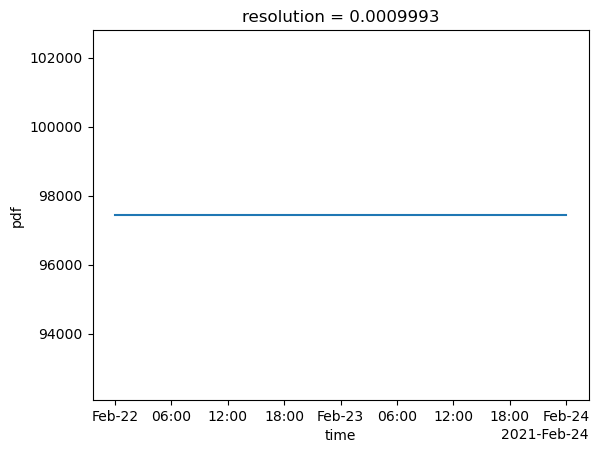

In [37]:
emission_with_bathy["pdf"].count(dims).plot()

In [38]:
from pangeo_fish.helpers import normalize_pdf

combined_diff_bathy = normalize_pdf(
    ds=emission_with_bathy,
    chunks=default_chunk_dims,
    dims=dims,
)[0]
combined_diff_bathy

<xarray.Dataset> Size: 7MB
Dimensions:     (cells: 103284, time: 3)
Coordinates:
  * cell_ids    (cells) int64 826kB 1105367 1105371 1105372 ... 1648725 1648726
    latitude    (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    longitude   (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    resolution  float64 8B 0.0009993
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
Dimensions without coordinates: cells
Data variables:
    initial     (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    final       (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    mask        (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    pdf         (time, cells) float64 2MB dask.array<chunksize=(1, 103284), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=10, indexing_scheme=nested, kind=pandas)
Attributes:
    grid_type:        healpix
    level:            10
    nside:            1024
    lat:              0
    lon:              0
    rot_lat:          0
    rot_lon:          0
    comment:          pangeo-fish == 2025.3.4.dev15+ge4fe03374.d20251103, hea...
    min_vertices:     1
    differences_std:  1.0
    recapture_std:    0.0001
    initial_std:      0.0001

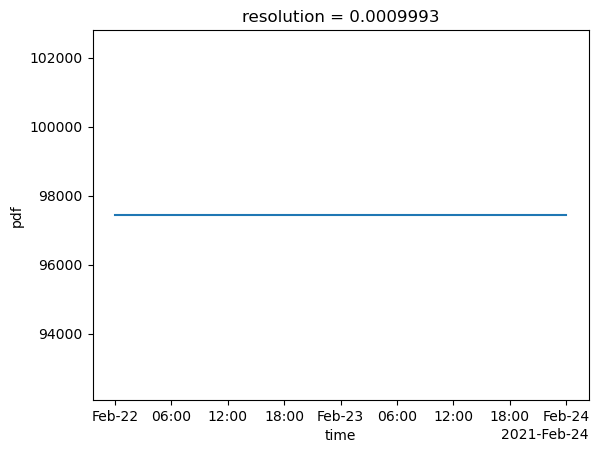

In [39]:
combined_diff_bathy["pdf"].count(dims).plot()

In [40]:
combined_diff_bathy.compute().to_zarr(
    f"{target_root}/emission_w_bathy_pdf_{tag_name}.zarr",
    compute=True,
    mode="w",
    consolidated=True,
    zarr_version=2,
    storage_options=storage_options,
)
del emission_pdf, combined_diff_bathy

/tmp/ipykernel_26258/3410565792.py:1: FutureWarning: zarr_version is deprecated, use zarr_format
  combined_diff_bathy.compute().to_zarr(


## 7. Estimate the model's parameters

It is now time to determine the parameters of the model based on the normalized emission matrix.

Precisely, is consists of finding the best `sigma`, which corresponds to the standard deviation of the Brownian motion that models the fish's movement between the time steps.  

To do so, in the following we:
1. Define the lower and upper bounds for `sigma`.  
2. Search for the best `sigma` with `optimize_pdf()`.
3. Save the results of the search (i.e., ` sigma`), along with any additional parameters used during the optimization, a human-readable `.json` file.  

In [8]:
from pangeo_fish.helpers import optimize_pdf

In [9]:
# Open the distributions
emission = xr.open_dataset(
    f"{target_root}/emission_w_bathy_pdf_{tag_name}.zarr",
    engine="zarr",
    chunks=default_chunk_dims,
    inline_array=True,
    storage_options=storage_options,
)
emission

<xarray.Dataset> Size: 7MB
Dimensions:     (cells: 103284, time: 3)
Coordinates:
    cell_ids    (cells) int64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    latitude    (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    longitude   (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 24B 2021-02-22 2021-02-23 2021-02-24
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    initial     (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    mask        (cells) float64 826kB dask.array<chunksize=(103284,), meta=np.ndarray>
    pdf         (time, cells) float64 2MB dask.array<chunksize=(1, 103284), meta=np.ndarray>
Attributes:
    grid_type:        healpix
    level:            10
    nside:            1024
    lat:              0
    lon:              0
    rot_lat:          0
    rot_lon:          0
    comment:          pangeo-fish == 2025.3.4.dev15+ge4fe03374.d20251103, hea...
    min_vertices:     1
    differences_std:  1.0
    recapture_std:    0.0001
    initial_std:      0.0001

In [10]:
emission.pdf.compute().dggs.decode(
    {"grid_name": "healpix", "level": 10, "indexing_scheme": "nested"}
).dggs.explore(alpha=0.8)

MapWithSliders(children=(Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro…

In [11]:
emission= emission.dggs.decode(
    {"grid_name": "healpix", "level": 10, "indexing_scheme": "nested"}
)

In [ ]:
%%time
# Define the parameter's bounds and search for the best value
params = optimize_pdf(
    ds=emission.compute(),
    earth_radius=earth_radius,
    adjustment_factor=adjustment_factor,
    truncate=truncate,
    maximum_speed=maximum_speed,
    tolerance=tolerance,
    dims=dims,
    # the results can be directly saved
    save_parameters=True,
    storage_options=storage_options,
    target_root=target_root,
)
params

0.09417673834562863
sigma 0.03597231927876448
sigma_opt 20.78229282112825
[[0.0004129  0.00044362 0.00047443 ... 0.00047443 0.00044362 0.0004129 ]
 [0.00044362 0.00047663 0.00050974 ... 0.00050974 0.00047663 0.00044362]
 [0.00047443 0.00050974 0.00054514 ... 0.00054514 0.00050974 0.00047443]
 ...
 [0.00047443 0.00050974 0.00054514 ... 0.00054514 0.00050974 0.00047443]
 [0.00044362 0.00047663 0.00050974 ... 0.00050974 0.00047663 0.00044362]
 [0.0004129  0.00044362 0.00047443 ... 0.00047443 0.00044362 0.0004129 ]]
kernel cut: [0.00074689 0.00080247 0.00085821 0.00091357 0.00096801 0.00102095
 0.00107182 0.00112003 0.00116499 0.00120616 0.00124302 0.00127508
 0.00130193 0.0013232  0.00133861 0.00134794 0.00135107 0.00134794
 0.00133861 0.0013232  0.00130193 0.00127508 0.00124302 0.00120616
 0.00116499 0.00112003 0.00107182 0.00102095 0.00096801 0.00091357
 0.00085821 0.00080247 0.00074689]


Scoring: 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


 
 Func-count     x          f(x)          Procedure
    1      0.0359723      24.8924        initial
sigma 0.05820442906686414
sigma_opt 33.62645257816986
[[0.00068199 0.00070094 0.00071915 ... 0.00071915 0.00070094 0.00068199]
 [0.00070094 0.00072043 0.00073914 ... 0.00073914 0.00072043 0.00070094]
 [0.00071915 0.00073914 0.00075834 ... 0.00075834 0.00073914 0.00071915]
 ...
 [0.00071915 0.00073914 0.00075834 ... 0.00075834 0.00073914 0.00071915]
 [0.00070094 0.00072043 0.00073914 ... 0.00073914 0.00072043 0.00070094]
 [0.00068199 0.00070094 0.00071915 ... 0.00071915 0.00070094 0.00068199]]
kernel cut: [0.00085527 0.00087904 0.00090187 0.00092367 0.00094432 0.00096372
 0.00098179 0.00099842 0.00101355 0.00102708 0.00103896 0.00104912
 0.0010575  0.00106407 0.00106878 0.00107162 0.00107257 0.00107162
 0.00106878 0.00106407 0.0010575  0.00104912 0.00103896 0.00102708
 0.00101355 0.00099842 0.00098179 0.00096372 0.00094432 0.00092367
 0.00090187 0.00087904 0.00085527]


Scoring: 100%|██████████| 2/2 [00:08<00:00,  4.32s/it]


    2      0.0582044      25.0978        golden
sigma 0.022232119788099667
sigma_opt 12.844165534342947
[[9.99526996e-05 1.20615413e-04 1.43795745e-04 ... 1.43795745e-04
  1.20615413e-04 9.99526996e-05]
 [1.20615413e-04 1.45549623e-04 1.73521908e-04 ... 1.73521908e-04
  1.45549623e-04 1.20615413e-04]
 [1.43795745e-04 1.73521908e-04 2.06870013e-04 ... 2.06870013e-04
  1.73521908e-04 1.43795745e-04]
 ...
 [1.43795745e-04 1.73521908e-04 2.06870013e-04 ... 2.06870013e-04
  1.73521908e-04 1.43795745e-04]
 [1.20615413e-04 1.45549623e-04 1.73521908e-04 ... 1.73521908e-04
  1.45549623e-04 1.20615413e-04]
 [9.99526996e-05 1.20615413e-04 1.43795745e-04 ... 1.43795745e-04
  1.20615413e-04 9.99526996e-05]]
kernel cut: [0.00047176 0.00056928 0.00067869 0.00079938 0.00093017 0.00106933
 0.00121449 0.00136274 0.00151066 0.00165445 0.0017901  0.00191353
 0.00202082 0.00210841 0.00217329 0.00221317 0.00222663 0.00221317
 0.00217329 0.00210841 0.00202082 0.00191353 0.0017901  0.00165445
 0.00151066 0.00

Scoring: 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


    3      0.0222321      24.3903        golden
sigma 0.01374020949066482
sigma_opt 7.938133064086644
[[1.50492438e-06 2.46131844e-06 3.89975085e-06 ... 3.89975085e-06
  2.46131844e-06 1.50492438e-06]
 [2.46131844e-06 4.02551023e-06 6.37808040e-06 ... 6.37808040e-06
  4.02551023e-06 2.46131844e-06]
 [3.89975085e-06 6.37808040e-06 1.01055288e-05 ... 1.01055288e-05
  6.37808040e-06 3.89975085e-06]
 ...
 [3.89975085e-06 6.37808040e-06 1.01055288e-05 ... 1.01055288e-05
  6.37808040e-06 3.89975085e-06]
 [2.46131844e-06 4.02551023e-06 6.37808040e-06 ... 6.37808040e-06
  4.02551023e-06 2.46131844e-06]
 [1.50492438e-06 2.46131844e-06 3.89975085e-06 ... 3.89975085e-06
  2.46131844e-06 1.50492438e-06]]
kernel cut: [8.74733975e-05 1.43063591e-04 2.26672158e-04 3.47923018e-04
 5.17349545e-04 7.45248153e-04 1.04000080e-03 1.40599043e-03
 1.84139510e-03 2.33629419e-03 2.87160038e-03 3.41929367e-03
 3.94425269e-03 4.40766912e-03 4.77165644e-03 5.00432234e-03
 5.08437193e-03 5.00432234e-03 4.77165644e

Scoring: 100%|██████████| 2/2 [00:08<00:00,  4.37s/it]


    4      0.0137402      23.5466        golden
sigma 0.008491920297434853
sigma_opt 4.906038247557641
[[7.63980660e-12 2.76970180e-11 9.24052237e-11 ... 9.24052237e-11
  2.76970180e-11 7.63980660e-12]
 [2.76970180e-11 1.00411548e-10 3.35001824e-10 ... 3.35001824e-10
  1.00411548e-10 2.76970180e-11]
 [9.24052237e-11 3.35001824e-10 1.11766250e-09 ... 1.11766250e-09
  3.35001824e-10 9.24052237e-11]
 ...
 [9.24052237e-11 3.35001824e-10 1.11766250e-09 ... 1.11766250e-09
  3.35001824e-10 9.24052237e-11]
 [2.76970180e-11 1.00411548e-10 3.35001824e-10 ... 3.35001824e-10
  1.00411548e-10 2.76970180e-11]
 [7.63980660e-12 2.76970180e-11 9.24052237e-11 ... 9.24052237e-11
  2.76970180e-11 7.63980660e-12]]
kernel cut: [3.17860166e-07 1.15235623e-06 3.84459206e-06 1.18039303e-05
 3.33515381e-05 8.67197390e-05 2.07507079e-04 4.56941638e-04
 9.25979586e-04 1.72685134e-03 2.96361205e-03 4.68059016e-03
 6.80287888e-03 9.09908504e-03 1.11999368e-02 1.26866301e-02
 1.32248224e-02 1.26866301e-02 1.11999368

Scoring: 100%|██████████| 2/2 [00:08<00:00,  4.44s/it]


    5     0.00849192      22.9155        golden


In [ ]:
target_root

## 8. State probabilities and Trajectories

In this second to last step, we calculate the spatial probability distribution (based on the `sigma` found earlier) and further compute trajectories.

_NB: the computation precisely relies on `sigma` and the combined emission pdf._

In [ ]:
from pangeo_fish.helpers import predict_positions

In [ ]:
emission = xr.open_dataset(
    f"{target_root}/emission_w_bathy_pdf_{tag_name}.zarr",
    engine="zarr",
    chunks=default_chunk_dims,
    inline_array=True,
    storage_options=storage_options,
)
emission

In [ ]:
%%time
states, trajectories = predict_positions(
    ds = emission.dggs.decode(
    {"grid_name": "healpix", "level": 10, "indexing_scheme": "nested"}
),
    target_root=target_root,
    storage_options=storage_options,
    chunks=default_chunk_dims,
    track_modes=track_modes,
    additional_track_quantities=additional_track_quantities,
    save=True,
    tag_name=tag_name
)

In [ ]:
states.states.compute().dggs.decode(
    {"grid_name": "healpix", "level": 10, "indexing_scheme": "nested"}
).dggs.explore(alpha=0.8)

In [ ]:
states.compute().to_zarr(
     f"{target_root}/states.zarr",
    compute=True,
    mode="w",
    consolidated=True,
    zarr_version=2,
    storage_options=storage_options,
)